In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [17]:
train_data = spark.read.option("inferSchema","true").csv("Clustering/BearTraining.csv", header=True)
train_data = train_data.select("Front Claws", "Pupillary Distance", "Ear Shape")
train_data = train_data.na.drop()

In [18]:
train_data = train_data.withColumn("Ear Shape", when(train_data["Ear Shape"]=="Rounded",0).when(train_data["Ear Shape"]=="Broad", 1).when(train_data["Ear Shape"]=="Pointed",2))

In [20]:
cols = train_data.columns
train_data = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(train_data)

In [21]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
train_data = scaler.fit(train_data).transform(train_data)

In [22]:
test_data = spark.read.option("inferSchema","true").csv("Clustering/BearTesting.csv", header=True)
test_data = test_data.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
test_data = test_data.na.drop()

In [24]:
test_data = test_data.withColumn("Ear Shape", when(test_data["Ear Shape"]=="Rounded",0).when(test_data["Ear Shape"]=="Broad", 1).when(test_data["Ear Shape"]=="Pointed",2))

test_data = test_data.withColumn("Grizzly", when(test_data["Grizzly"]=="Yes",1).otherwise(0))

In [26]:
cols = test_data.columns
cols.remove("Grizzly")
test_data = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(test_data)

In [28]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
test_data = scaler.fit(test_data).transform(test_data)

In [29]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(train_data)

In [30]:
predictions = model.transform(test_data)

In [32]:
predictions = predictions.toPandas()

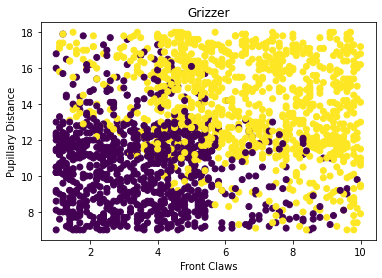

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Front Claws"], predictions["Pupillary Distance"], c=predictions["prediction"])
ax.set_xlabel("Front Claws")
ax.set_ylabel("Pupillary Distance")
plt.title("Grizzer")
plt.show()

In [37]:
count = 0
for index, row in predictions.iterrows():
    if row ["Grizzly"]==row["prediction"]:
        count+=1
    
print("Accuracy: {}%".format(count/len(predictions)*100))

Accuracy: 83.55%
